In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])
plt.rcParams["figure.figsize"] = (8, 4)

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dataset 

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

#data_path = "../thesis/dataset/EthenT/"
#postfix = "EthenT"
#dim = 72
#N_ELECTRONS = 16
#basis = "6-311++g**"
data_path = "../thesis/dataset/TSmall/"
postfix = "TSmall"
dim = 70
N_ELECTRONS = 30
basis = "3-21++g*"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#[S, P] = np.load()
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


#ind = int(0.8 * len(index))
ind = 0

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])
#molecules = ([], molecules)

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test = S.reshape(-1, dim, dim)
#p_test = S.reshape(-1, dim, dim)

In [3]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    #train=(None, None),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [4]:
def f(x,y):
    return 4*x + 6 * y
f(13,3)

70

In [5]:
from pyscf.scf import hf
h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

# Utilities 

In [6]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd(p_guess, p_conv))
    return np.array(p_embedded)


In [7]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

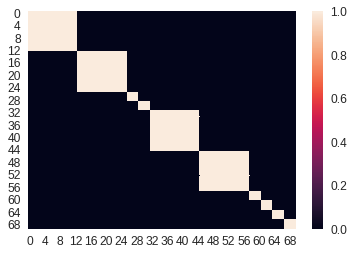

In [8]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [9]:
np.mean(np.abs(p_test.flatten() - embedd_batch(p_test).flatten()))

0.0

In [10]:
from pyscf.scf import hf
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

In [11]:
from SCFInitialGuess.utilities.dataset import density_from_fock

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)


# GWH 

In [12]:
from pyscf.scf import hf

p_gwh = np.array([ 
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [13]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 12:58:22: Iteration calculation: 0
[ ] 2019-01-07 12:58:24: Iteration calculation: 1
[ ] 2019-01-07 12:58:26: Iteration calculation: 2
[ ] 2019-01-07 12:58:29: Iteration calculation: 3
[ ] 2019-01-07 12:58:31: Iteration calculation: 4
[ ] 2019-01-07 12:58:33: Iteration calculation: 5
[ ] 2019-01-07 12:58:36: Iteration calculation: 6
[ ] 2019-01-07 12:58:38: Iteration calculation: 7
[ ] 2019-01-07 12:58:40: Iteration calculation: 8
[ ] 2019-01-07 12:58:42: Iteration calculation: 9
[ ] 2019-01-07 12:58:44: Iteration calculation: 10
[ ] 2019-01-07 12:58:46: Iteration calculation: 11
[ ] 2019-01-07 12:58:48: Iteration calculation: 12
[ ] 2019-01-07 12:58:50: Iteration calculation: 13
[ ] 2019-01-07 12:58:52: Iteration calculation: 14
[ ] 2019-01-07 12:58:54: Iteration calculation: 15
[ ] 2019-01-07 12:58:56: Iteration calculation: 16
[ ] 2019-01-07 12:58:57: Iteration calculation: 17
[ ] 2019-01-07 12:58:58: Iteration calculation: 18
[ ] 2019-01-07 12:58:59: Iteration calcul

[ ] 2019-01-07 13:03:29: Iteration calculation: 160
[ ] 2019-01-07 13:03:30: Iteration calculation: 161
[ ] 2019-01-07 13:03:31: Iteration calculation: 162
[ ] 2019-01-07 13:03:32: Iteration calculation: 163
[ ] 2019-01-07 13:03:32: Iteration calculation: 164
[ ] 2019-01-07 13:03:33: Iteration calculation: 165
[ ] 2019-01-07 13:03:34: Iteration calculation: 166
[ ] 2019-01-07 13:03:35: Iteration calculation: 167
[ ] 2019-01-07 13:03:36: Iteration calculation: 168
[ ] 2019-01-07 13:03:37: Iteration calculation: 169
[ ] 2019-01-07 13:03:38: Iteration calculation: 170
[ ] 2019-01-07 13:03:40: Iteration calculation: 171
[ ] 2019-01-07 13:03:41: Iteration calculation: 172
[ ] 2019-01-07 13:03:42: Iteration calculation: 173
[ ] 2019-01-07 13:03:44: Iteration calculation: 174
[ ] 2019-01-07 13:03:45: Iteration calculation: 175
[ ] 2019-01-07 13:03:48: Iteration calculation: 176
[ ] 2019-01-07 13:03:49: Iteration calculation: 177
[ ] 2019-01-07 13:03:51: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 13:07:39: Iteration calculation: 318
[ ] 2019-01-07 13:07:41: Iteration calculation: 319
[ ] 2019-01-07 13:07:43: Iteration calculation: 320
[ ] 2019-01-07 13:07:45: Iteration calculation: 321
[ ] 2019-01-07 13:07:47: Iteration calculation: 322
[ ] 2019-01-07 13:07:49: Iteration calculation: 323
[ ] 2019-01-07 13:07:51: Iteration calculation: 324
[ ] 2019-01-07 13:07:53: Iteration calculation: 325
[ ] 2019-01-07 13:07:55: Iteration calculation: 326
[ ] 2019-01-07 13:07:57: Iteration calculation: 327
[ ] 2019-01-07 13:08:00: Iteration calculation: 328
[ ] 2019-01-07 13:08:02: Iteration calculation: 329
[ ] 2019-01-07 13:08:04: Iteration calculation: 330
[ ] 2019-01-07 13:08:07: Iteration calculation: 331
[ ] 2019-01-07 13:08:10: Iteration calculation: 332
[ ] 2019-01-07 13:08:12: Iteration calculation: 333
[ ] 2019-01-07 13:08:14: Iteration calculation: 334
[ ] 2019-01-07 13:08:16: Iteration calculation: 335
[ ] 2019-01-07 13:08:18: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 13:12:44: Iteration calculation: 476
[ ] 2019-01-07 13:12:46: Iteration calculation: 477
[ ] 2019-01-07 13:12:48: Iteration calculation: 478
[ ] 2019-01-07 13:12:49: Iteration calculation: 479
[ ] 2019-01-07 13:12:50: Iteration calculation: 480
[ ] 2019-01-07 13:12:51: Iteration calculation: 481
[ ] 2019-01-07 13:12:53: Iteration calculation: 482
[ ] 2019-01-07 13:12:54: Iteration calculation: 483
[ ] 2019-01-07 13:12:55: Iteration calculation: 484
[ ] 2019-01-07 13:12:56: Iteration calculation: 485
[ ] 2019-01-07 13:12:59: Iteration calculation: 486
[ ] 2019-01-07 13:13:01: Iteration calculation: 487
[ ] 2019-01-07 13:13:03: Iteration calculation: 488
[ ] 2019-01-07 13:13:05: Iteration calculation: 489
[ ] 2019-01-07 13:13:07: Iteration calculation: 490
[ ] 2019-01-07 13:13:09: Iteration calculation: 491
[ ] 2019-01-07 13:13:11: Iteration calculation: 492
[ ] 2019-01-07 13:13:14: Iteration calculation: 493
[ ] 2019-01-07 13:13:16: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 13:17:38: Iteration calculation: 634
[ ] 2019-01-07 13:17:40: Iteration calculation: 635
[ ] 2019-01-07 13:17:42: Iteration calculation: 636
[ ] 2019-01-07 13:17:44: Iteration calculation: 637
[ ] 2019-01-07 13:17:46: Iteration calculation: 638
[ ] 2019-01-07 13:17:48: Iteration calculation: 639
[ ] 2019-01-07 13:17:50: Iteration calculation: 640
[ ] 2019-01-07 13:17:52: Iteration calculation: 641
[ ] 2019-01-07 13:17:54: Iteration calculation: 642
[ ] 2019-01-07 13:17:56: Iteration calculation: 643
[ ] 2019-01-07 13:17:58: Iteration calculation: 644
[ ] 2019-01-07 13:18:00: Iteration calculation: 645
[ ] 2019-01-07 13:18:02: Iteration calculation: 646
[ ] 2019-01-07 13:18:04: Iteration calculation: 647
[ ] 2019-01-07 13:18:06: Iteration calculation: 648
[ ] 2019-01-07 13:18:08: Iteration calculation: 649
[ ] 2019-01-07 13:18:10: Iteration calculation: 650
[ ] 2019-01-07 13:18:12: Iteration calculation: 651
[ ] 2019-01-07 13:18:14: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 13:23:04: Iteration calculation: 792
[ ] 2019-01-07 13:23:06: Iteration calculation: 793
[ ] 2019-01-07 13:23:09: Iteration calculation: 794
[ ] 2019-01-07 13:23:11: Iteration calculation: 795
[ ] 2019-01-07 13:23:13: Iteration calculation: 796
[ ] 2019-01-07 13:23:15: Iteration calculation: 797
[ ] 2019-01-07 13:23:17: Iteration calculation: 798
[ ] 2019-01-07 13:23:19: Iteration calculation: 799
[ ] 2019-01-07 13:23:21: Iteration calculation: 800
[ ] 2019-01-07 13:23:23: Iteration calculation: 801
[ ] 2019-01-07 13:23:24: Iteration calculation: 802
[ ] 2019-01-07 13:23:26: Iteration calculation: 803
[ ] 2019-01-07 13:23:28: Iteration calculation: 804
[ ] 2019-01-07 13:23:30: Iteration calculation: 805
[ ] 2019-01-07 13:23:32: Iteration calculation: 806
[ ] 2019-01-07 13:23:35: Iteration calculation: 807
[ ] 2019-01-07 13:23:37: Iteration calculation: 808
[ ] 2019-01-07 13:23:39: Iteration calculation: 809
[ ] 2019-01-07 13:23:40: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 13:27:37: Iteration calculation: 950
[ ] 2019-01-07 13:27:39: Iteration calculation: 951
[ ] 2019-01-07 13:27:41: Iteration calculation: 952
[ ] 2019-01-07 13:27:43: Iteration calculation: 953
[ ] 2019-01-07 13:27:45: Iteration calculation: 954
[ ] 2019-01-07 13:27:47: Iteration calculation: 955
[ ] 2019-01-07 13:27:49: Iteration calculation: 956
[ ] 2019-01-07 13:27:51: Iteration calculation: 957
[ ] 2019-01-07 13:27:53: Iteration calculation: 958
[ ] 2019-01-07 13:27:55: Iteration calculation: 959
[ ] 2019-01-07 13:27:57: Iteration calculation: 960
[ ] 2019-01-07 13:27:59: Iteration calculation: 961
[ ] 2019-01-07 13:28:01: Iteration calculation: 962
[ ] 2019-01-07 13:28:03: Iteration calculation: 963
[ ] 2019-01-07 13:28:05: Iteration calculation: 964
[ ] 2019-01-07 13:28:07: Iteration calculation: 965
[ ] 2019-01-07 13:28:09: Iteration calculation: 966
[ ] 2019-01-07 13:28:11: Iteration calculation: 967
[ ] 2019-01-07 13:28:13: Iteration calculation: 968
[ ] 2019-01-

# Embedded GWH 

In [14]:
p_embedded_gwh = embedd_batch(p_gwh)

In [15]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 13:37:56: Iteration calculation: 0
[ ] 2019-01-07 13:37:58: Iteration calculation: 1
[ ] 2019-01-07 13:38:00: Iteration calculation: 2
[ ] 2019-01-07 13:38:02: Iteration calculation: 3
[ ] 2019-01-07 13:38:04: Iteration calculation: 4
[ ] 2019-01-07 13:38:07: Iteration calculation: 5
[ ] 2019-01-07 13:38:09: Iteration calculation: 6
[ ] 2019-01-07 13:38:11: Iteration calculation: 7
[ ] 2019-01-07 13:38:13: Iteration calculation: 8
[ ] 2019-01-07 13:38:15: Iteration calculation: 9
[ ] 2019-01-07 13:38:17: Iteration calculation: 10
[ ] 2019-01-07 13:38:19: Iteration calculation: 11
[ ] 2019-01-07 13:38:21: Iteration calculation: 12
[ ] 2019-01-07 13:38:23: Iteration calculation: 13
[ ] 2019-01-07 13:38:25: Iteration calculation: 14
[ ] 2019-01-07 13:38:27: Iteration calculation: 15
[ ] 2019-01-07 13:38:29: Iteration calculation: 16
[ ] 2019-01-07 13:38:30: Iteration calculation: 17
[ ] 2019-01-07 13:38:31: Iteration calculation: 18
[ ] 2019-01-07 13:38:32: Iteration calcul

[ ] 2019-01-07 13:43:14: Iteration calculation: 160
[ ] 2019-01-07 13:43:17: Iteration calculation: 161
[ ] 2019-01-07 13:43:19: Iteration calculation: 162
[ ] 2019-01-07 13:43:21: Iteration calculation: 163
[ ] 2019-01-07 13:43:23: Iteration calculation: 164
[ ] 2019-01-07 13:43:25: Iteration calculation: 165
[ ] 2019-01-07 13:43:27: Iteration calculation: 166
[ ] 2019-01-07 13:43:30: Iteration calculation: 167
[ ] 2019-01-07 13:43:32: Iteration calculation: 168
[ ] 2019-01-07 13:43:34: Iteration calculation: 169
[ ] 2019-01-07 13:43:36: Iteration calculation: 170
[ ] 2019-01-07 13:43:38: Iteration calculation: 171
[ ] 2019-01-07 13:43:40: Iteration calculation: 172
[ ] 2019-01-07 13:43:42: Iteration calculation: 173
[ ] 2019-01-07 13:43:44: Iteration calculation: 174
[ ] 2019-01-07 13:43:46: Iteration calculation: 175
[ ] 2019-01-07 13:43:48: Iteration calculation: 176
[ ] 2019-01-07 13:43:50: Iteration calculation: 177
[ ] 2019-01-07 13:43:53: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 13:47:28: Iteration calculation: 318
[ ] 2019-01-07 13:47:30: Iteration calculation: 319
[ ] 2019-01-07 13:47:32: Iteration calculation: 320
[ ] 2019-01-07 13:47:34: Iteration calculation: 321
[ ] 2019-01-07 13:47:36: Iteration calculation: 322
[ ] 2019-01-07 13:47:38: Iteration calculation: 323
[ ] 2019-01-07 13:47:40: Iteration calculation: 324
[ ] 2019-01-07 13:47:42: Iteration calculation: 325
[ ] 2019-01-07 13:47:44: Iteration calculation: 326
[ ] 2019-01-07 13:47:46: Iteration calculation: 327
[ ] 2019-01-07 13:47:48: Iteration calculation: 328
[ ] 2019-01-07 13:47:50: Iteration calculation: 329
[ ] 2019-01-07 13:47:52: Iteration calculation: 330
[ ] 2019-01-07 13:47:54: Iteration calculation: 331
[ ] 2019-01-07 13:47:56: Iteration calculation: 332
[ ] 2019-01-07 13:47:58: Iteration calculation: 333
[ ] 2019-01-07 13:48:00: Iteration calculation: 334
[ ] 2019-01-07 13:48:02: Iteration calculation: 335
[ ] 2019-01-07 13:48:04: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 13:52:40: Iteration calculation: 476
[ ] 2019-01-07 13:52:42: Iteration calculation: 477
[ ] 2019-01-07 13:52:43: Iteration calculation: 478
[ ] 2019-01-07 13:52:45: Iteration calculation: 479
[ ] 2019-01-07 13:52:47: Iteration calculation: 480
[ ] 2019-01-07 13:52:49: Iteration calculation: 481
[ ] 2019-01-07 13:52:50: Iteration calculation: 482
[ ] 2019-01-07 13:52:51: Iteration calculation: 483
[ ] 2019-01-07 13:52:52: Iteration calculation: 484
[ ] 2019-01-07 13:52:53: Iteration calculation: 485
[ ] 2019-01-07 13:52:53: Iteration calculation: 486
[ ] 2019-01-07 13:52:54: Iteration calculation: 487
[ ] 2019-01-07 13:52:55: Iteration calculation: 488
[ ] 2019-01-07 13:52:56: Iteration calculation: 489
[ ] 2019-01-07 13:52:58: Iteration calculation: 490
[ ] 2019-01-07 13:53:00: Iteration calculation: 491
[ ] 2019-01-07 13:53:02: Iteration calculation: 492
[ ] 2019-01-07 13:53:04: Iteration calculation: 493
[ ] 2019-01-07 13:53:06: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 13:57:52: Iteration calculation: 634
[ ] 2019-01-07 13:57:54: Iteration calculation: 635
[ ] 2019-01-07 13:57:57: Iteration calculation: 636
[ ] 2019-01-07 13:57:59: Iteration calculation: 637
[ ] 2019-01-07 13:58:01: Iteration calculation: 638
[ ] 2019-01-07 13:58:03: Iteration calculation: 639
[ ] 2019-01-07 13:58:05: Iteration calculation: 640
[ ] 2019-01-07 13:58:07: Iteration calculation: 641
[ ] 2019-01-07 13:58:09: Iteration calculation: 642
[ ] 2019-01-07 13:58:11: Iteration calculation: 643
[ ] 2019-01-07 13:58:13: Iteration calculation: 644
[ ] 2019-01-07 13:58:15: Iteration calculation: 645
[ ] 2019-01-07 13:58:17: Iteration calculation: 646
[ ] 2019-01-07 13:58:19: Iteration calculation: 647
[ ] 2019-01-07 13:58:21: Iteration calculation: 648
[ ] 2019-01-07 13:58:24: Iteration calculation: 649
[ ] 2019-01-07 13:58:26: Iteration calculation: 650
[ ] 2019-01-07 13:58:28: Iteration calculation: 651
[ ] 2019-01-07 13:58:30: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 14:03:08: Iteration calculation: 792
[ ] 2019-01-07 14:03:10: Iteration calculation: 793
[ ] 2019-01-07 14:03:12: Iteration calculation: 794
[ ] 2019-01-07 14:03:14: Iteration calculation: 795
[ ] 2019-01-07 14:03:16: Iteration calculation: 796
[ ] 2019-01-07 14:03:18: Iteration calculation: 797
[ ] 2019-01-07 14:03:20: Iteration calculation: 798
[ ] 2019-01-07 14:03:22: Iteration calculation: 799
[ ] 2019-01-07 14:03:24: Iteration calculation: 800
[ ] 2019-01-07 14:03:26: Iteration calculation: 801
[ ] 2019-01-07 14:03:28: Iteration calculation: 802
[ ] 2019-01-07 14:03:31: Iteration calculation: 803
[ ] 2019-01-07 14:03:33: Iteration calculation: 804
[ ] 2019-01-07 14:03:35: Iteration calculation: 805
[ ] 2019-01-07 14:03:37: Iteration calculation: 806
[ ] 2019-01-07 14:03:39: Iteration calculation: 807
[ ] 2019-01-07 14:03:41: Iteration calculation: 808
[ ] 2019-01-07 14:03:43: Iteration calculation: 809
[ ] 2019-01-07 14:03:45: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 14:08:19: Iteration calculation: 950
[ ] 2019-01-07 14:08:21: Iteration calculation: 951
[ ] 2019-01-07 14:08:23: Iteration calculation: 952
[ ] 2019-01-07 14:08:25: Iteration calculation: 953
[ ] 2019-01-07 14:08:27: Iteration calculation: 954
[ ] 2019-01-07 14:08:29: Iteration calculation: 955
[ ] 2019-01-07 14:08:31: Iteration calculation: 956
[ ] 2019-01-07 14:08:33: Iteration calculation: 957
[ ] 2019-01-07 14:08:35: Iteration calculation: 958
[ ] 2019-01-07 14:08:37: Iteration calculation: 959
[ ] 2019-01-07 14:08:39: Iteration calculation: 960
[ ] 2019-01-07 14:08:41: Iteration calculation: 961
[ ] 2019-01-07 14:08:43: Iteration calculation: 962
[ ] 2019-01-07 14:08:45: Iteration calculation: 963
[ ] 2019-01-07 14:08:47: Iteration calculation: 964
[ ] 2019-01-07 14:08:49: Iteration calculation: 965
[ ] 2019-01-07 14:08:51: Iteration calculation: 966
[ ] 2019-01-07 14:08:53: Iteration calculation: 967
[ ] 2019-01-07 14:08:55: Iteration calculation: 968
[ ] 2019-01-

In [16]:
51/1001

0.05094905094905095

# Embedded GWH + 1 Iteration

In [17]:
f_embedded_gwh = fock_from_density_batch(p_embedded_gwh)
p_embedded_gwh_test = density_from_fock_batch(f_embedded_gwh)

In [18]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 14:24:40: Iteration calculation: 0
[ ] 2019-01-07 14:24:42: Iteration calculation: 1
[ ] 2019-01-07 14:24:44: Iteration calculation: 2
[ ] 2019-01-07 14:24:47: Iteration calculation: 3
[ ] 2019-01-07 14:24:49: Iteration calculation: 4
[ ] 2019-01-07 14:24:51: Iteration calculation: 5
[ ] 2019-01-07 14:24:53: Iteration calculation: 6
[ ] 2019-01-07 14:24:55: Iteration calculation: 7
[ ] 2019-01-07 14:24:57: Iteration calculation: 8
[ ] 2019-01-07 14:24:59: Iteration calculation: 9
[ ] 2019-01-07 14:25:01: Iteration calculation: 10
[ ] 2019-01-07 14:25:03: Iteration calculation: 11
[ ] 2019-01-07 14:25:05: Iteration calculation: 12
[ ] 2019-01-07 14:25:07: Iteration calculation: 13
[ ] 2019-01-07 14:25:10: Iteration calculation: 14
[ ] 2019-01-07 14:25:12: Iteration calculation: 15
[ ] 2019-01-07 14:25:14: Iteration calculation: 16
[ ] 2019-01-07 14:25:15: Iteration calculation: 17
[ ] 2019-01-07 14:25:16: Iteration calculation: 18
[ ] 2019-01-07 14:25:17: Iteration calcul

[ ] 2019-01-07 14:29:54: Iteration calculation: 160
[ ] 2019-01-07 14:29:56: Iteration calculation: 161
[ ] 2019-01-07 14:29:58: Iteration calculation: 162
[ ] 2019-01-07 14:30:00: Iteration calculation: 163
[ ] 2019-01-07 14:30:02: Iteration calculation: 164
[ ] 2019-01-07 14:30:04: Iteration calculation: 165
[ ] 2019-01-07 14:30:07: Iteration calculation: 166
[ ] 2019-01-07 14:30:09: Iteration calculation: 167
[ ] 2019-01-07 14:30:11: Iteration calculation: 168
[ ] 2019-01-07 14:30:13: Iteration calculation: 169
[ ] 2019-01-07 14:30:15: Iteration calculation: 170
[ ] 2019-01-07 14:30:17: Iteration calculation: 171
[ ] 2019-01-07 14:30:19: Iteration calculation: 172
[ ] 2019-01-07 14:30:21: Iteration calculation: 173
[ ] 2019-01-07 14:30:23: Iteration calculation: 174
[ ] 2019-01-07 14:30:25: Iteration calculation: 175
[ ] 2019-01-07 14:30:27: Iteration calculation: 176
[ ] 2019-01-07 14:30:29: Iteration calculation: 177
[ ] 2019-01-07 14:30:32: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 14:34:06: Iteration calculation: 318
[ ] 2019-01-07 14:34:08: Iteration calculation: 319
[ ] 2019-01-07 14:34:10: Iteration calculation: 320
[ ] 2019-01-07 14:34:12: Iteration calculation: 321
[ ] 2019-01-07 14:34:14: Iteration calculation: 322
[ ] 2019-01-07 14:34:16: Iteration calculation: 323
[ ] 2019-01-07 14:34:18: Iteration calculation: 324
[ ] 2019-01-07 14:34:20: Iteration calculation: 325
[ ] 2019-01-07 14:34:22: Iteration calculation: 326
[ ] 2019-01-07 14:34:24: Iteration calculation: 327
[ ] 2019-01-07 14:34:25: Iteration calculation: 328
[ ] 2019-01-07 14:34:27: Iteration calculation: 329
[ ] 2019-01-07 14:34:29: Iteration calculation: 330
[ ] 2019-01-07 14:34:31: Iteration calculation: 331
[ ] 2019-01-07 14:34:33: Iteration calculation: 332
[ ] 2019-01-07 14:34:35: Iteration calculation: 333
[ ] 2019-01-07 14:34:37: Iteration calculation: 334
[ ] 2019-01-07 14:34:39: Iteration calculation: 335
[ ] 2019-01-07 14:34:41: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 14:39:19: Iteration calculation: 476
[ ] 2019-01-07 14:39:20: Iteration calculation: 477
[ ] 2019-01-07 14:39:22: Iteration calculation: 478
[ ] 2019-01-07 14:39:24: Iteration calculation: 479
[ ] 2019-01-07 14:39:26: Iteration calculation: 480
[ ] 2019-01-07 14:39:28: Iteration calculation: 481
[ ] 2019-01-07 14:39:29: Iteration calculation: 482
[ ] 2019-01-07 14:39:30: Iteration calculation: 483
[ ] 2019-01-07 14:39:31: Iteration calculation: 484
[ ] 2019-01-07 14:39:31: Iteration calculation: 485
[ ] 2019-01-07 14:39:32: Iteration calculation: 486
[ ] 2019-01-07 14:39:33: Iteration calculation: 487
[ ] 2019-01-07 14:39:34: Iteration calculation: 488
[ ] 2019-01-07 14:39:35: Iteration calculation: 489
[ ] 2019-01-07 14:39:38: Iteration calculation: 490
[ ] 2019-01-07 14:39:40: Iteration calculation: 491
[ ] 2019-01-07 14:39:42: Iteration calculation: 492
[ ] 2019-01-07 14:39:44: Iteration calculation: 493
[ ] 2019-01-07 14:39:46: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 14:44:28: Iteration calculation: 634
[ ] 2019-01-07 14:44:30: Iteration calculation: 635
[ ] 2019-01-07 14:44:32: Iteration calculation: 636
[ ] 2019-01-07 14:44:34: Iteration calculation: 637
[ ] 2019-01-07 14:44:36: Iteration calculation: 638
[ ] 2019-01-07 14:44:38: Iteration calculation: 639
[ ] 2019-01-07 14:44:40: Iteration calculation: 640
[ ] 2019-01-07 14:44:42: Iteration calculation: 641
[ ] 2019-01-07 14:44:44: Iteration calculation: 642
[ ] 2019-01-07 14:44:46: Iteration calculation: 643
[ ] 2019-01-07 14:44:48: Iteration calculation: 644
[ ] 2019-01-07 14:44:50: Iteration calculation: 645
[ ] 2019-01-07 14:44:52: Iteration calculation: 646
[ ] 2019-01-07 14:44:54: Iteration calculation: 647
[ ] 2019-01-07 14:44:55: Iteration calculation: 648
[ ] 2019-01-07 14:44:57: Iteration calculation: 649
[ ] 2019-01-07 14:44:59: Iteration calculation: 650
[ ] 2019-01-07 14:45:01: Iteration calculation: 651
[ ] 2019-01-07 14:45:03: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 14:49:50: Iteration calculation: 792
[ ] 2019-01-07 14:49:52: Iteration calculation: 793
[ ] 2019-01-07 14:49:54: Iteration calculation: 794
[ ] 2019-01-07 14:49:56: Iteration calculation: 795
[ ] 2019-01-07 14:49:58: Iteration calculation: 796
[ ] 2019-01-07 14:50:00: Iteration calculation: 797
[ ] 2019-01-07 14:50:01: Iteration calculation: 798
[ ] 2019-01-07 14:50:03: Iteration calculation: 799
[ ] 2019-01-07 14:50:05: Iteration calculation: 800
[ ] 2019-01-07 14:50:07: Iteration calculation: 801
[ ] 2019-01-07 14:50:09: Iteration calculation: 802
[ ] 2019-01-07 14:50:11: Iteration calculation: 803
[ ] 2019-01-07 14:50:13: Iteration calculation: 804
[ ] 2019-01-07 14:50:15: Iteration calculation: 805
[ ] 2019-01-07 14:50:17: Iteration calculation: 806
[ ] 2019-01-07 14:50:18: Iteration calculation: 807
[ ] 2019-01-07 14:50:20: Iteration calculation: 808
[ ] 2019-01-07 14:50:22: Iteration calculation: 809
[ ] 2019-01-07 14:50:24: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 14:55:02: Iteration calculation: 950
[ ] 2019-01-07 14:55:03: Iteration calculation: 951
[ ] 2019-01-07 14:55:05: Iteration calculation: 952
[ ] 2019-01-07 14:55:07: Iteration calculation: 953
[ ] 2019-01-07 14:55:09: Iteration calculation: 954
[ ] 2019-01-07 14:55:11: Iteration calculation: 955
[ ] 2019-01-07 14:55:13: Iteration calculation: 956
[ ] 2019-01-07 14:55:15: Iteration calculation: 957
[ ] 2019-01-07 14:55:17: Iteration calculation: 958
[ ] 2019-01-07 14:55:19: Iteration calculation: 959
[ ] 2019-01-07 14:55:20: Iteration calculation: 960
[ ] 2019-01-07 14:55:22: Iteration calculation: 961
[ ] 2019-01-07 14:55:24: Iteration calculation: 962
[ ] 2019-01-07 14:55:26: Iteration calculation: 963
[ ] 2019-01-07 14:55:28: Iteration calculation: 964
[ ] 2019-01-07 14:55:30: Iteration calculation: 965
[ ] 2019-01-07 14:55:32: Iteration calculation: 966
[ ] 2019-01-07 14:55:34: Iteration calculation: 967
[ ] 2019-01-07 14:55:36: Iteration calculation: 968
[ ] 2019-01-

# SAD 

In [19]:
from pyscf.scf import hf

p_sad = np.array([ 
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

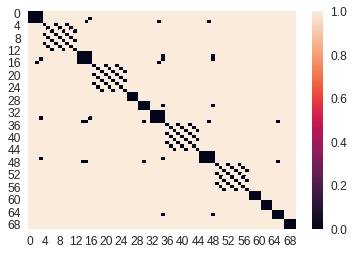

In [20]:
sns.heatmap((abs(p_sad[0]) < 1e-12).astype("int"))

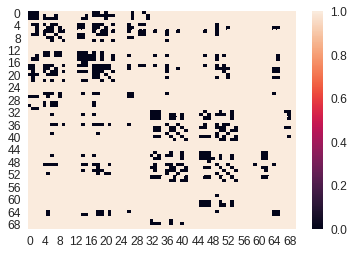

In [21]:
sns.heatmap((abs(p_gwh[0]) < 0.05).astype("int"))

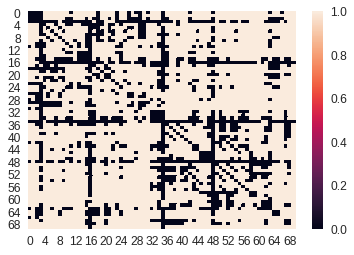

In [22]:
sns.heatmap((abs(p_test[30]) < 0.05).astype("int"))

In [23]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 15:08:34: Iteration calculation: 0
[ ] 2019-01-07 15:08:35: Iteration calculation: 1
[ ] 2019-01-07 15:08:36: Iteration calculation: 2
[ ] 2019-01-07 15:08:38: Iteration calculation: 3
[ ] 2019-01-07 15:08:39: Iteration calculation: 4
[ ] 2019-01-07 15:08:40: Iteration calculation: 5
[ ] 2019-01-07 15:08:42: Iteration calculation: 6
[ ] 2019-01-07 15:08:43: Iteration calculation: 7
[ ] 2019-01-07 15:08:45: Iteration calculation: 8
[ ] 2019-01-07 15:08:46: Iteration calculation: 9
[ ] 2019-01-07 15:08:47: Iteration calculation: 10
[ ] 2019-01-07 15:08:48: Iteration calculation: 11
[ ] 2019-01-07 15:08:49: Iteration calculation: 12
[ ] 2019-01-07 15:08:50: Iteration calculation: 13
[ ] 2019-01-07 15:08:51: Iteration calculation: 14
[ ] 2019-01-07 15:08:52: Iteration calculation: 15
[ ] 2019-01-07 15:08:53: Iteration calculation: 16
[ ] 2019-01-07 15:08:54: Iteration calculation: 17
[ ] 2019-01-07 15:08:54: Iteration calculation: 18
[ ] 2019-01-07 15:08:55: Iteration calcul

[ ] 2019-01-07 15:12:07: Iteration calculation: 160
[ ] 2019-01-07 15:12:07: Iteration calculation: 161
[ ] 2019-01-07 15:12:08: Iteration calculation: 162
[ ] 2019-01-07 15:12:09: Iteration calculation: 163
[ ] 2019-01-07 15:12:09: Iteration calculation: 164
[ ] 2019-01-07 15:12:10: Iteration calculation: 165
[ ] 2019-01-07 15:12:11: Iteration calculation: 166
[ ] 2019-01-07 15:12:12: Iteration calculation: 167
[ ] 2019-01-07 15:12:13: Iteration calculation: 168
[ ] 2019-01-07 15:12:13: Iteration calculation: 169
[ ] 2019-01-07 15:12:14: Iteration calculation: 170
[ ] 2019-01-07 15:12:15: Iteration calculation: 171
[ ] 2019-01-07 15:12:17: Iteration calculation: 172
[ ] 2019-01-07 15:12:18: Iteration calculation: 173
[ ] 2019-01-07 15:12:19: Iteration calculation: 174
[ ] 2019-01-07 15:12:20: Iteration calculation: 175
[ ] 2019-01-07 15:12:21: Iteration calculation: 176
[ ] 2019-01-07 15:12:22: Iteration calculation: 177
[ ] 2019-01-07 15:12:23: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 15:14:38: Iteration calculation: 318
[ ] 2019-01-07 15:14:39: Iteration calculation: 319
[ ] 2019-01-07 15:14:40: Iteration calculation: 320
[ ] 2019-01-07 15:14:41: Iteration calculation: 321
[ ] 2019-01-07 15:14:42: Iteration calculation: 322
[ ] 2019-01-07 15:14:42: Iteration calculation: 323
[ ] 2019-01-07 15:14:43: Iteration calculation: 324
[ ] 2019-01-07 15:14:44: Iteration calculation: 325
[ ] 2019-01-07 15:14:45: Iteration calculation: 326
[ ] 2019-01-07 15:14:45: Iteration calculation: 327
[ ] 2019-01-07 15:14:46: Iteration calculation: 328
[ ] 2019-01-07 15:14:47: Iteration calculation: 329
[ ] 2019-01-07 15:14:47: Iteration calculation: 330
[ ] 2019-01-07 15:14:48: Iteration calculation: 331
[ ] 2019-01-07 15:14:49: Iteration calculation: 332
[ ] 2019-01-07 15:14:50: Iteration calculation: 333
[ ] 2019-01-07 15:14:50: Iteration calculation: 334
[ ] 2019-01-07 15:14:51: Iteration calculation: 335
[ ] 2019-01-07 15:14:51: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 15:17:13: Iteration calculation: 476
[ ] 2019-01-07 15:17:14: Iteration calculation: 477
[ ] 2019-01-07 15:17:16: Iteration calculation: 478
[ ] 2019-01-07 15:17:17: Iteration calculation: 479
[ ] 2019-01-07 15:17:18: Iteration calculation: 480
[ ] 2019-01-07 15:17:19: Iteration calculation: 481
[ ] 2019-01-07 15:17:20: Iteration calculation: 482
[ ] 2019-01-07 15:17:21: Iteration calculation: 483
[ ] 2019-01-07 15:17:22: Iteration calculation: 484
[ ] 2019-01-07 15:17:23: Iteration calculation: 485
[ ] 2019-01-07 15:17:24: Iteration calculation: 486
[ ] 2019-01-07 15:17:25: Iteration calculation: 487
[ ] 2019-01-07 15:17:25: Iteration calculation: 488
[ ] 2019-01-07 15:17:27: Iteration calculation: 489
[ ] 2019-01-07 15:17:28: Iteration calculation: 490
[ ] 2019-01-07 15:17:29: Iteration calculation: 491
[ ] 2019-01-07 15:17:30: Iteration calculation: 492
[ ] 2019-01-07 15:17:31: Iteration calculation: 493
[ ] 2019-01-07 15:17:32: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 15:19:28: Iteration calculation: 634
[ ] 2019-01-07 15:19:29: Iteration calculation: 635
[ ] 2019-01-07 15:19:29: Iteration calculation: 636
[ ] 2019-01-07 15:19:30: Iteration calculation: 637
[ ] 2019-01-07 15:19:31: Iteration calculation: 638
[ ] 2019-01-07 15:19:32: Iteration calculation: 639
[ ] 2019-01-07 15:19:33: Iteration calculation: 640
[ ] 2019-01-07 15:19:33: Iteration calculation: 641
[ ] 2019-01-07 15:19:34: Iteration calculation: 642
[ ] 2019-01-07 15:19:35: Iteration calculation: 643
[ ] 2019-01-07 15:19:36: Iteration calculation: 644
[ ] 2019-01-07 15:19:37: Iteration calculation: 645
[ ] 2019-01-07 15:19:38: Iteration calculation: 646
[ ] 2019-01-07 15:19:38: Iteration calculation: 647
[ ] 2019-01-07 15:19:39: Iteration calculation: 648
[ ] 2019-01-07 15:19:40: Iteration calculation: 649
[ ] 2019-01-07 15:19:41: Iteration calculation: 650
[ ] 2019-01-07 15:19:42: Iteration calculation: 651
[ ] 2019-01-07 15:19:43: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 15:21:40: Iteration calculation: 792
[ ] 2019-01-07 15:21:41: Iteration calculation: 793
[ ] 2019-01-07 15:21:42: Iteration calculation: 794
[ ] 2019-01-07 15:21:43: Iteration calculation: 795
[ ] 2019-01-07 15:21:44: Iteration calculation: 796
[ ] 2019-01-07 15:21:45: Iteration calculation: 797
[ ] 2019-01-07 15:21:46: Iteration calculation: 798
[ ] 2019-01-07 15:21:47: Iteration calculation: 799
[ ] 2019-01-07 15:21:48: Iteration calculation: 800
[ ] 2019-01-07 15:21:49: Iteration calculation: 801
[ ] 2019-01-07 15:21:50: Iteration calculation: 802
[ ] 2019-01-07 15:21:51: Iteration calculation: 803
[ ] 2019-01-07 15:21:52: Iteration calculation: 804
[ ] 2019-01-07 15:21:53: Iteration calculation: 805
[ ] 2019-01-07 15:21:54: Iteration calculation: 806
[ ] 2019-01-07 15:21:55: Iteration calculation: 807
[ ] 2019-01-07 15:21:56: Iteration calculation: 808
[ ] 2019-01-07 15:21:57: Iteration calculation: 809
[ ] 2019-01-07 15:21:58: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 15:24:41: Iteration calculation: 950
[ ] 2019-01-07 15:24:42: Iteration calculation: 951
[ ] 2019-01-07 15:24:43: Iteration calculation: 952
[ ] 2019-01-07 15:24:44: Iteration calculation: 953
[ ] 2019-01-07 15:24:45: Iteration calculation: 954
[ ] 2019-01-07 15:24:46: Iteration calculation: 955
[ ] 2019-01-07 15:24:47: Iteration calculation: 956
[ ] 2019-01-07 15:24:47: Iteration calculation: 957
[ ] 2019-01-07 15:24:48: Iteration calculation: 958
[ ] 2019-01-07 15:24:49: Iteration calculation: 959
[ ] 2019-01-07 15:24:50: Iteration calculation: 960
[ ] 2019-01-07 15:24:50: Iteration calculation: 961
[ ] 2019-01-07 15:24:51: Iteration calculation: 962
[ ] 2019-01-07 15:24:52: Iteration calculation: 963
[ ] 2019-01-07 15:24:52: Iteration calculation: 964
[ ] 2019-01-07 15:24:53: Iteration calculation: 965
[ ] 2019-01-07 15:24:54: Iteration calculation: 966
[ ] 2019-01-07 15:24:55: Iteration calculation: 967
[ ] 2019-01-07 15:24:56: Iteration calculation: 968
[ ] 2019-01-

In [24]:
47/1001

0.04695304695304695

# Embedded zeros 

In [25]:
p_embedded_zeros = embedd_batch(np.zeros(p_test.shape))

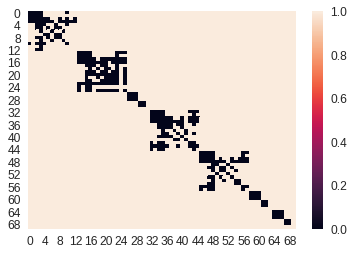

In [26]:
sns.heatmap((abs(p_embedded_zeros[0]) < 0.05).astype("int"))

In [27]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_zeros,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 15:34:40: Iteration calculation: 0
[ ] 2019-01-07 15:34:42: Iteration calculation: 1
[ ] 2019-01-07 15:34:44: Iteration calculation: 2
[ ] 2019-01-07 15:34:46: Iteration calculation: 3
[ ] 2019-01-07 15:34:48: Iteration calculation: 4
[ ] 2019-01-07 15:34:50: Iteration calculation: 5
[ ] 2019-01-07 15:34:52: Iteration calculation: 6
[ ] 2019-01-07 15:34:53: Iteration calculation: 7
[ ] 2019-01-07 15:34:54: Iteration calculation: 8
[ ] 2019-01-07 15:34:56: Iteration calculation: 9
[ ] 2019-01-07 15:34:57: Iteration calculation: 10
[ ] 2019-01-07 15:34:58: Iteration calculation: 11
[ ] 2019-01-07 15:34:59: Iteration calculation: 12
[ ] 2019-01-07 15:35:00: Iteration calculation: 13
[ ] 2019-01-07 15:35:01: Iteration calculation: 14
[ ] 2019-01-07 15:35:02: Iteration calculation: 15
[ ] 2019-01-07 15:35:03: Iteration calculation: 16
[ ] 2019-01-07 15:35:03: Iteration calculation: 17
[ ] 2019-01-07 15:35:04: Iteration calculation: 18
[ ] 2019-01-07 15:35:06: Iteration calcul

[ ] 2019-01-07 15:39:06: Iteration calculation: 160
[ ] 2019-01-07 15:39:08: Iteration calculation: 161
[ ] 2019-01-07 15:39:10: Iteration calculation: 162
[ ] 2019-01-07 15:39:10: Iteration calculation: 163
[ ] 2019-01-07 15:39:11: Iteration calculation: 164
[ ] 2019-01-07 15:39:12: Iteration calculation: 165
[ ] 2019-01-07 15:39:13: Iteration calculation: 166
[ ] 2019-01-07 15:39:14: Iteration calculation: 167
[ ] 2019-01-07 15:39:15: Iteration calculation: 168
[ ] 2019-01-07 15:39:16: Iteration calculation: 169
[ ] 2019-01-07 15:39:17: Iteration calculation: 170
[ ] 2019-01-07 15:39:18: Iteration calculation: 171
[ ] 2019-01-07 15:39:19: Iteration calculation: 172
[ ] 2019-01-07 15:39:21: Iteration calculation: 173
[ ] 2019-01-07 15:39:23: Iteration calculation: 174
[ ] 2019-01-07 15:39:25: Iteration calculation: 175
[ ] 2019-01-07 15:39:27: Iteration calculation: 176
[ ] 2019-01-07 15:39:29: Iteration calculation: 177
[ ] 2019-01-07 15:39:31: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 15:42:44: Iteration calculation: 318
[ ] 2019-01-07 15:42:44: Iteration calculation: 319
[ ] 2019-01-07 15:42:45: Iteration calculation: 320
[ ] 2019-01-07 15:42:46: Iteration calculation: 321
[ ] 2019-01-07 15:42:47: Iteration calculation: 322
[ ] 2019-01-07 15:42:47: Iteration calculation: 323
[ ] 2019-01-07 15:42:48: Iteration calculation: 324
[ ] 2019-01-07 15:42:49: Iteration calculation: 325
[ ] 2019-01-07 15:42:50: Iteration calculation: 326
[ ] 2019-01-07 15:42:51: Iteration calculation: 327
[ ] 2019-01-07 15:42:52: Iteration calculation: 328
[ ] 2019-01-07 15:42:53: Iteration calculation: 329
[ ] 2019-01-07 15:42:53: Iteration calculation: 330
[ ] 2019-01-07 15:42:54: Iteration calculation: 331
[ ] 2019-01-07 15:42:55: Iteration calculation: 332
[ ] 2019-01-07 15:42:58: Iteration calculation: 333
[ ] 2019-01-07 15:43:00: Iteration calculation: 334
[ ] 2019-01-07 15:43:02: Iteration calculation: 335
[ ] 2019-01-07 15:43:04: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 15:46:54: Iteration calculation: 476
[ ] 2019-01-07 15:46:55: Iteration calculation: 477
[ ] 2019-01-07 15:46:57: Iteration calculation: 478
[ ] 2019-01-07 15:46:58: Iteration calculation: 479
[ ] 2019-01-07 15:47:00: Iteration calculation: 480
[ ] 2019-01-07 15:47:01: Iteration calculation: 481
[ ] 2019-01-07 15:47:03: Iteration calculation: 482
[ ] 2019-01-07 15:47:04: Iteration calculation: 483
[ ] 2019-01-07 15:47:05: Iteration calculation: 484
[ ] 2019-01-07 15:47:06: Iteration calculation: 485
[ ] 2019-01-07 15:47:07: Iteration calculation: 486
[ ] 2019-01-07 15:47:08: Iteration calculation: 487
[ ] 2019-01-07 15:47:09: Iteration calculation: 488
[ ] 2019-01-07 15:47:10: Iteration calculation: 489
[ ] 2019-01-07 15:47:11: Iteration calculation: 490
[ ] 2019-01-07 15:47:13: Iteration calculation: 491
[ ] 2019-01-07 15:47:15: Iteration calculation: 492
[ ] 2019-01-07 15:47:17: Iteration calculation: 493
[ ] 2019-01-07 15:47:19: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 15:50:25: Iteration calculation: 634
[ ] 2019-01-07 15:50:26: Iteration calculation: 635
[ ] 2019-01-07 15:50:28: Iteration calculation: 636
[ ] 2019-01-07 15:50:30: Iteration calculation: 637
[ ] 2019-01-07 15:50:32: Iteration calculation: 638
[ ] 2019-01-07 15:50:34: Iteration calculation: 639
[ ] 2019-01-07 15:50:37: Iteration calculation: 640
[ ] 2019-01-07 15:50:39: Iteration calculation: 641
[ ] 2019-01-07 15:50:41: Iteration calculation: 642
[ ] 2019-01-07 15:50:43: Iteration calculation: 643
[ ] 2019-01-07 15:50:45: Iteration calculation: 644
[ ] 2019-01-07 15:50:48: Iteration calculation: 645
[ ] 2019-01-07 15:50:50: Iteration calculation: 646
[ ] 2019-01-07 15:50:52: Iteration calculation: 647
[ ] 2019-01-07 15:50:54: Iteration calculation: 648
[ ] 2019-01-07 15:50:56: Iteration calculation: 649
[ ] 2019-01-07 15:50:58: Iteration calculation: 650
[ ] 2019-01-07 15:51:00: Iteration calculation: 651
[ ] 2019-01-07 15:51:02: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 15:55:10: Iteration calculation: 792
[ ] 2019-01-07 15:55:12: Iteration calculation: 793
[ ] 2019-01-07 15:55:14: Iteration calculation: 794
[ ] 2019-01-07 15:55:16: Iteration calculation: 795
[ ] 2019-01-07 15:55:17: Iteration calculation: 796
[ ] 2019-01-07 15:55:19: Iteration calculation: 797
[ ] 2019-01-07 15:55:21: Iteration calculation: 798
[ ] 2019-01-07 15:55:23: Iteration calculation: 799
[ ] 2019-01-07 15:55:25: Iteration calculation: 800
[ ] 2019-01-07 15:55:27: Iteration calculation: 801
[ ] 2019-01-07 15:55:29: Iteration calculation: 802
[ ] 2019-01-07 15:55:31: Iteration calculation: 803
[ ] 2019-01-07 15:55:33: Iteration calculation: 804
[ ] 2019-01-07 15:55:35: Iteration calculation: 805
[ ] 2019-01-07 15:55:36: Iteration calculation: 806
[ ] 2019-01-07 15:55:38: Iteration calculation: 807
[ ] 2019-01-07 15:55:40: Iteration calculation: 808
[ ] 2019-01-07 15:55:42: Iteration calculation: 809
[ ] 2019-01-07 15:55:44: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 15:59:39: Iteration calculation: 950
[ ] 2019-01-07 15:59:41: Iteration calculation: 951
[ ] 2019-01-07 15:59:42: Iteration calculation: 952
[ ] 2019-01-07 15:59:43: Iteration calculation: 953
[ ] 2019-01-07 15:59:44: Iteration calculation: 954
[ ] 2019-01-07 15:59:46: Iteration calculation: 955
[ ] 2019-01-07 15:59:48: Iteration calculation: 956
[ ] 2019-01-07 15:59:50: Iteration calculation: 957
[ ] 2019-01-07 15:59:52: Iteration calculation: 958
[ ] 2019-01-07 15:59:54: Iteration calculation: 959
[ ] 2019-01-07 15:59:56: Iteration calculation: 960
[ ] 2019-01-07 15:59:58: Iteration calculation: 961
[ ] 2019-01-07 15:59:59: Iteration calculation: 962
[ ] 2019-01-07 16:00:00: Iteration calculation: 963
[ ] 2019-01-07 16:00:01: Iteration calculation: 964
[ ] 2019-01-07 16:00:02: Iteration calculation: 965
[ ] 2019-01-07 16:00:03: Iteration calculation: 966
[ ] 2019-01-07 16:00:04: Iteration calculation: 967
[ ] 2019-01-07 16:00:05: Iteration calculation: 968
[ ] 2019-01-

# Embedded zeros + 1 Iteration? 

In [28]:
f_embedded_zeros = fock_from_density_batch(p_embedded_zeros)
p_embedded_zeros_test = density_from_fock_batch(f_embedded_zeros,)

In [29]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    p_embedded_zeros_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 16:16:18: Iteration calculation: 0
[ ] 2019-01-07 16:16:20: Iteration calculation: 1
[ ] 2019-01-07 16:16:22: Iteration calculation: 2
[ ] 2019-01-07 16:16:24: Iteration calculation: 3
[ ] 2019-01-07 16:16:26: Iteration calculation: 4
[ ] 2019-01-07 16:16:28: Iteration calculation: 5
[ ] 2019-01-07 16:16:29: Iteration calculation: 6
[ ] 2019-01-07 16:16:31: Iteration calculation: 7
[ ] 2019-01-07 16:16:32: Iteration calculation: 8
[ ] 2019-01-07 16:16:34: Iteration calculation: 9
[ ] 2019-01-07 16:16:35: Iteration calculation: 10
[ ] 2019-01-07 16:16:36: Iteration calculation: 11
[ ] 2019-01-07 16:16:37: Iteration calculation: 12
[ ] 2019-01-07 16:16:38: Iteration calculation: 13
[ ] 2019-01-07 16:16:39: Iteration calculation: 14
[ ] 2019-01-07 16:16:39: Iteration calculation: 15
[ ] 2019-01-07 16:16:40: Iteration calculation: 16
[ ] 2019-01-07 16:16:41: Iteration calculation: 17
[ ] 2019-01-07 16:16:42: Iteration calculation: 18
[ ] 2019-01-07 16:16:43: Iteration calcul

[ ] 2019-01-07 16:20:42: Iteration calculation: 160
[ ] 2019-01-07 16:20:44: Iteration calculation: 161
[ ] 2019-01-07 16:20:46: Iteration calculation: 162
[ ] 2019-01-07 16:20:47: Iteration calculation: 163
[ ] 2019-01-07 16:20:48: Iteration calculation: 164
[ ] 2019-01-07 16:20:49: Iteration calculation: 165
[ ] 2019-01-07 16:20:49: Iteration calculation: 166
[ ] 2019-01-07 16:20:50: Iteration calculation: 167
[ ] 2019-01-07 16:20:51: Iteration calculation: 168
[ ] 2019-01-07 16:20:52: Iteration calculation: 169
[ ] 2019-01-07 16:20:53: Iteration calculation: 170
[ ] 2019-01-07 16:20:55: Iteration calculation: 171
[ ] 2019-01-07 16:20:56: Iteration calculation: 172
[ ] 2019-01-07 16:20:57: Iteration calculation: 173
[ ] 2019-01-07 16:20:59: Iteration calculation: 174
[ ] 2019-01-07 16:21:02: Iteration calculation: 175
[ ] 2019-01-07 16:21:04: Iteration calculation: 176
[ ] 2019-01-07 16:21:06: Iteration calculation: 177
[ ] 2019-01-07 16:21:08: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 16:24:23: Iteration calculation: 318
[ ] 2019-01-07 16:24:24: Iteration calculation: 319
[ ] 2019-01-07 16:24:25: Iteration calculation: 320
[ ] 2019-01-07 16:24:25: Iteration calculation: 321
[ ] 2019-01-07 16:24:26: Iteration calculation: 322
[ ] 2019-01-07 16:24:27: Iteration calculation: 323
[ ] 2019-01-07 16:24:28: Iteration calculation: 324
[ ] 2019-01-07 16:24:29: Iteration calculation: 325
[ ] 2019-01-07 16:24:30: Iteration calculation: 326
[ ] 2019-01-07 16:24:31: Iteration calculation: 327
[ ] 2019-01-07 16:24:32: Iteration calculation: 328
[ ] 2019-01-07 16:24:33: Iteration calculation: 329
[ ] 2019-01-07 16:24:34: Iteration calculation: 330
[ ] 2019-01-07 16:24:35: Iteration calculation: 331
[ ] 2019-01-07 16:24:35: Iteration calculation: 332
[ ] 2019-01-07 16:24:38: Iteration calculation: 333
[ ] 2019-01-07 16:24:40: Iteration calculation: 334
[ ] 2019-01-07 16:24:42: Iteration calculation: 335
[ ] 2019-01-07 16:24:44: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 16:28:40: Iteration calculation: 476
[ ] 2019-01-07 16:28:41: Iteration calculation: 477
[ ] 2019-01-07 16:28:43: Iteration calculation: 478
[ ] 2019-01-07 16:28:44: Iteration calculation: 479
[ ] 2019-01-07 16:28:46: Iteration calculation: 480
[ ] 2019-01-07 16:28:47: Iteration calculation: 481
[ ] 2019-01-07 16:28:48: Iteration calculation: 482
[ ] 2019-01-07 16:28:49: Iteration calculation: 483
[ ] 2019-01-07 16:28:51: Iteration calculation: 484
[ ] 2019-01-07 16:28:52: Iteration calculation: 485
[ ] 2019-01-07 16:28:53: Iteration calculation: 486
[ ] 2019-01-07 16:28:54: Iteration calculation: 487
[ ] 2019-01-07 16:28:55: Iteration calculation: 488
[ ] 2019-01-07 16:28:56: Iteration calculation: 489
[ ] 2019-01-07 16:28:57: Iteration calculation: 490
[ ] 2019-01-07 16:28:58: Iteration calculation: 491
[ ] 2019-01-07 16:29:00: Iteration calculation: 492
[ ] 2019-01-07 16:29:02: Iteration calculation: 493
[ ] 2019-01-07 16:29:04: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 16:32:11: Iteration calculation: 634
[ ] 2019-01-07 16:32:12: Iteration calculation: 635
[ ] 2019-01-07 16:32:14: Iteration calculation: 636
[ ] 2019-01-07 16:32:16: Iteration calculation: 637
[ ] 2019-01-07 16:32:19: Iteration calculation: 638
[ ] 2019-01-07 16:32:21: Iteration calculation: 639
[ ] 2019-01-07 16:32:23: Iteration calculation: 640
[ ] 2019-01-07 16:32:25: Iteration calculation: 641
[ ] 2019-01-07 16:32:27: Iteration calculation: 642
[ ] 2019-01-07 16:32:30: Iteration calculation: 643
[ ] 2019-01-07 16:32:32: Iteration calculation: 644
[ ] 2019-01-07 16:32:34: Iteration calculation: 645
[ ] 2019-01-07 16:32:36: Iteration calculation: 646
[ ] 2019-01-07 16:32:39: Iteration calculation: 647
[ ] 2019-01-07 16:32:41: Iteration calculation: 648
[ ] 2019-01-07 16:32:43: Iteration calculation: 649
[ ] 2019-01-07 16:32:45: Iteration calculation: 650
[ ] 2019-01-07 16:32:47: Iteration calculation: 651
[ ] 2019-01-07 16:32:49: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 16:36:58: Iteration calculation: 792
[ ] 2019-01-07 16:37:00: Iteration calculation: 793
[ ] 2019-01-07 16:37:03: Iteration calculation: 794
[ ] 2019-01-07 16:37:05: Iteration calculation: 795
[ ] 2019-01-07 16:37:07: Iteration calculation: 796
[ ] 2019-01-07 16:37:09: Iteration calculation: 797
[ ] 2019-01-07 16:37:11: Iteration calculation: 798
[ ] 2019-01-07 16:37:13: Iteration calculation: 799
[ ] 2019-01-07 16:37:15: Iteration calculation: 800
[ ] 2019-01-07 16:37:17: Iteration calculation: 801
[ ] 2019-01-07 16:37:20: Iteration calculation: 802
[ ] 2019-01-07 16:37:22: Iteration calculation: 803
[ ] 2019-01-07 16:37:24: Iteration calculation: 804
[ ] 2019-01-07 16:37:26: Iteration calculation: 805
[ ] 2019-01-07 16:37:28: Iteration calculation: 806
[ ] 2019-01-07 16:37:31: Iteration calculation: 807
[ ] 2019-01-07 16:37:33: Iteration calculation: 808
[ ] 2019-01-07 16:37:35: Iteration calculation: 809
[ ] 2019-01-07 16:37:37: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 16:41:43: Iteration calculation: 950
[ ] 2019-01-07 16:41:44: Iteration calculation: 951
[ ] 2019-01-07 16:41:46: Iteration calculation: 952
[ ] 2019-01-07 16:41:47: Iteration calculation: 953
[ ] 2019-01-07 16:41:48: Iteration calculation: 954
[ ] 2019-01-07 16:41:50: Iteration calculation: 955
[ ] 2019-01-07 16:41:52: Iteration calculation: 956
[ ] 2019-01-07 16:41:54: Iteration calculation: 957
[ ] 2019-01-07 16:41:56: Iteration calculation: 958
[ ] 2019-01-07 16:41:58: Iteration calculation: 959
[ ] 2019-01-07 16:42:00: Iteration calculation: 960
[ ] 2019-01-07 16:42:02: Iteration calculation: 961
[ ] 2019-01-07 16:42:03: Iteration calculation: 962
[ ] 2019-01-07 16:42:03: Iteration calculation: 963
[ ] 2019-01-07 16:42:04: Iteration calculation: 964
[ ] 2019-01-07 16:42:05: Iteration calculation: 965
[ ] 2019-01-07 16:42:06: Iteration calculation: 966
[ ] 2019-01-07 16:42:07: Iteration calculation: 967
[ ] 2019-01-07 16:42:08: Iteration calculation: 968
[ ] 2019-01-

#  

In [30]:
77/1001

0.07692307692307693

# Embedded GWH w/ Self-Overlap 

In [31]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask_self_overlap = np.zeros((dim, dim))

current_dim_i = 0
for i, atom_i in enumerate(mol.species):
    
    
    # calculate block range
    index_start_i = current_dim_i
    current_dim_i += N_BASIS[basis][atom_i] 
    index_end_i = current_dim_i
    
    # calculate logical vector
    L_i = np.arange(dim)
    L_i = np.logical_and(index_start_i <= L_i, L_i < index_end_i)
    
    current_dim_j = 0
    for j, atom_j in enumerate(mol.species):
        

        #print(str(i) + ", " + str(j))    
        #print(str(atom_i) + ", " + str(atom_j))
        
        # calculate block range
        index_start_j = current_dim_j
        current_dim_j += N_BASIS[basis][atom_j] 
        index_end_j = current_dim_j

        if i == j:
            continue
        
        if atom_i == atom_j:
            # calculate logical vector
            L_j = np.arange(dim)
            L_j = np.logical_and(index_start_j <= L_j, L_j < index_end_j)


            m = np.logical_and.outer(L_i, L_j)
            
            mask_self_overlap = np.logical_or(mask_self_overlap, m)
    
#mask

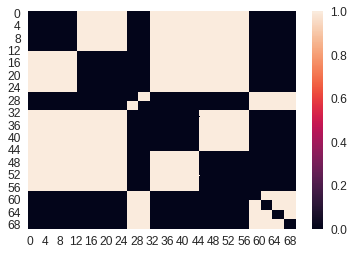

In [32]:
import seaborn as sns

sns.heatmap(mask_self_overlap.astype("int"))

In [33]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_self_ovlp(x, y):
    p = x.copy()
    p[mask_self_overlap] = (y.copy())[mask_self_overlap]
    return p

def embedd_batch_self_ovlp(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_self_ovlp(p_guess, p_conv))
    return np.array(p_embedded)


In [34]:
p_embedded_gwh_self_ovlp = embedd_batch_self_ovlp(p_embedded_gwh)

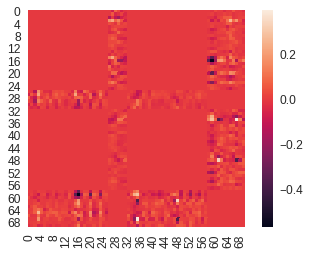

In [35]:
sns.heatmap(p_embedded_gwh_self_ovlp[0] - p_test[0], square=True)

In [36]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(fock_from_density_batch(p_embedded_gwh_self_ovlp)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 16:58:40: Iteration calculation: 0
[ ] 2019-01-07 16:58:41: Iteration calculation: 1
[ ] 2019-01-07 16:58:42: Iteration calculation: 2
[ ] 2019-01-07 16:58:43: Iteration calculation: 3
[ ] 2019-01-07 16:58:44: Iteration calculation: 4
[ ] 2019-01-07 16:58:46: Iteration calculation: 5
[ ] 2019-01-07 16:58:47: Iteration calculation: 6
[ ] 2019-01-07 16:58:48: Iteration calculation: 7
[ ] 2019-01-07 16:58:49: Iteration calculation: 8
[ ] 2019-01-07 16:58:51: Iteration calculation: 9
[ ] 2019-01-07 16:58:52: Iteration calculation: 10
[ ] 2019-01-07 16:58:53: Iteration calculation: 11
[ ] 2019-01-07 16:58:54: Iteration calculation: 12
[ ] 2019-01-07 16:58:55: Iteration calculation: 13
[ ] 2019-01-07 16:58:56: Iteration calculation: 14
[ ] 2019-01-07 16:58:57: Iteration calculation: 15
[ ] 2019-01-07 16:58:58: Iteration calculation: 16
[ ] 2019-01-07 16:58:59: Iteration calculation: 17
[ ] 2019-01-07 16:59:00: Iteration calculation: 18
[ ] 2019-01-07 16:59:01: Iteration calcul

[ ] 2019-01-07 17:02:10: Iteration calculation: 160
[ ] 2019-01-07 17:02:11: Iteration calculation: 161
[ ] 2019-01-07 17:02:11: Iteration calculation: 162
[ ] 2019-01-07 17:02:12: Iteration calculation: 163
[ ] 2019-01-07 17:02:13: Iteration calculation: 164
[ ] 2019-01-07 17:02:13: Iteration calculation: 165
[ ] 2019-01-07 17:02:14: Iteration calculation: 166
[ ] 2019-01-07 17:02:15: Iteration calculation: 167
[ ] 2019-01-07 17:02:15: Iteration calculation: 168
[ ] 2019-01-07 17:02:16: Iteration calculation: 169
[ ] 2019-01-07 17:02:17: Iteration calculation: 170
[ ] 2019-01-07 17:02:18: Iteration calculation: 171
[ ] 2019-01-07 17:02:19: Iteration calculation: 172
[ ] 2019-01-07 17:02:20: Iteration calculation: 173
[ ] 2019-01-07 17:02:21: Iteration calculation: 174
[ ] 2019-01-07 17:02:22: Iteration calculation: 175
[ ] 2019-01-07 17:02:22: Iteration calculation: 176
[ ] 2019-01-07 17:02:23: Iteration calculation: 177
[ ] 2019-01-07 17:02:24: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 17:04:43: Iteration calculation: 318
[ ] 2019-01-07 17:04:44: Iteration calculation: 319
[ ] 2019-01-07 17:04:44: Iteration calculation: 320
[ ] 2019-01-07 17:04:45: Iteration calculation: 321
[ ] 2019-01-07 17:04:46: Iteration calculation: 322
[ ] 2019-01-07 17:04:47: Iteration calculation: 323
[ ] 2019-01-07 17:04:48: Iteration calculation: 324
[ ] 2019-01-07 17:04:48: Iteration calculation: 325
[ ] 2019-01-07 17:04:49: Iteration calculation: 326
[ ] 2019-01-07 17:04:50: Iteration calculation: 327
[ ] 2019-01-07 17:04:50: Iteration calculation: 328
[ ] 2019-01-07 17:04:51: Iteration calculation: 329
[ ] 2019-01-07 17:04:52: Iteration calculation: 330
[ ] 2019-01-07 17:04:53: Iteration calculation: 331
[ ] 2019-01-07 17:04:53: Iteration calculation: 332
[ ] 2019-01-07 17:04:54: Iteration calculation: 333
[ ] 2019-01-07 17:04:55: Iteration calculation: 334
[ ] 2019-01-07 17:04:55: Iteration calculation: 335
[ ] 2019-01-07 17:04:56: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 17:07:21: Iteration calculation: 476
[ ] 2019-01-07 17:07:22: Iteration calculation: 477
[ ] 2019-01-07 17:07:23: Iteration calculation: 478
[ ] 2019-01-07 17:07:24: Iteration calculation: 479
[ ] 2019-01-07 17:07:25: Iteration calculation: 480
[ ] 2019-01-07 17:07:27: Iteration calculation: 481
[ ] 2019-01-07 17:07:28: Iteration calculation: 482
[ ] 2019-01-07 17:07:28: Iteration calculation: 483
[ ] 2019-01-07 17:07:29: Iteration calculation: 484
[ ] 2019-01-07 17:07:30: Iteration calculation: 485
[ ] 2019-01-07 17:07:31: Iteration calculation: 486
[ ] 2019-01-07 17:07:32: Iteration calculation: 487
[ ] 2019-01-07 17:07:33: Iteration calculation: 488
[ ] 2019-01-07 17:07:33: Iteration calculation: 489
[ ] 2019-01-07 17:07:34: Iteration calculation: 490
[ ] 2019-01-07 17:07:35: Iteration calculation: 491
[ ] 2019-01-07 17:07:35: Iteration calculation: 492
[ ] 2019-01-07 17:07:36: Iteration calculation: 493
[ ] 2019-01-07 17:07:37: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 17:09:30: Iteration calculation: 634
[ ] 2019-01-07 17:09:31: Iteration calculation: 635
[ ] 2019-01-07 17:09:32: Iteration calculation: 636
[ ] 2019-01-07 17:09:32: Iteration calculation: 637
[ ] 2019-01-07 17:09:33: Iteration calculation: 638
[ ] 2019-01-07 17:09:34: Iteration calculation: 639
[ ] 2019-01-07 17:09:35: Iteration calculation: 640
[ ] 2019-01-07 17:09:35: Iteration calculation: 641
[ ] 2019-01-07 17:09:36: Iteration calculation: 642
[ ] 2019-01-07 17:09:37: Iteration calculation: 643
[ ] 2019-01-07 17:09:37: Iteration calculation: 644
[ ] 2019-01-07 17:09:38: Iteration calculation: 645
[ ] 2019-01-07 17:09:39: Iteration calculation: 646
[ ] 2019-01-07 17:09:39: Iteration calculation: 647
[ ] 2019-01-07 17:09:40: Iteration calculation: 648
[ ] 2019-01-07 17:09:41: Iteration calculation: 649
[ ] 2019-01-07 17:09:42: Iteration calculation: 650
[ ] 2019-01-07 17:09:43: Iteration calculation: 651
[ ] 2019-01-07 17:09:43: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 17:11:38: Iteration calculation: 792
[ ] 2019-01-07 17:11:39: Iteration calculation: 793
[ ] 2019-01-07 17:11:40: Iteration calculation: 794
[ ] 2019-01-07 17:11:41: Iteration calculation: 795
[ ] 2019-01-07 17:11:42: Iteration calculation: 796
[ ] 2019-01-07 17:11:43: Iteration calculation: 797
[ ] 2019-01-07 17:11:44: Iteration calculation: 798
[ ] 2019-01-07 17:11:45: Iteration calculation: 799
[ ] 2019-01-07 17:11:46: Iteration calculation: 800
[ ] 2019-01-07 17:11:47: Iteration calculation: 801
[ ] 2019-01-07 17:11:49: Iteration calculation: 802
[ ] 2019-01-07 17:11:50: Iteration calculation: 803
[ ] 2019-01-07 17:11:51: Iteration calculation: 804
[ ] 2019-01-07 17:11:52: Iteration calculation: 805
[ ] 2019-01-07 17:11:53: Iteration calculation: 806
[ ] 2019-01-07 17:11:53: Iteration calculation: 807
[ ] 2019-01-07 17:11:54: Iteration calculation: 808
[ ] 2019-01-07 17:11:55: Iteration calculation: 809
[ ] 2019-01-07 17:11:56: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 17:14:57: Iteration calculation: 950
[ ] 2019-01-07 17:14:58: Iteration calculation: 951
[ ] 2019-01-07 17:15:00: Iteration calculation: 952
[ ] 2019-01-07 17:15:01: Iteration calculation: 953
[ ] 2019-01-07 17:15:02: Iteration calculation: 954
[ ] 2019-01-07 17:15:03: Iteration calculation: 955
[ ] 2019-01-07 17:15:03: Iteration calculation: 956
[ ] 2019-01-07 17:15:04: Iteration calculation: 957
[ ] 2019-01-07 17:15:05: Iteration calculation: 958
[ ] 2019-01-07 17:15:06: Iteration calculation: 959
[ ] 2019-01-07 17:15:07: Iteration calculation: 960
[ ] 2019-01-07 17:15:07: Iteration calculation: 961
[ ] 2019-01-07 17:15:08: Iteration calculation: 962
[ ] 2019-01-07 17:15:09: Iteration calculation: 963
[ ] 2019-01-07 17:15:10: Iteration calculation: 964
[ ] 2019-01-07 17:15:10: Iteration calculation: 965
[ ] 2019-01-07 17:15:11: Iteration calculation: 966
[ ] 2019-01-07 17:15:12: Iteration calculation: 967
[ ] 2019-01-07 17:15:13: Iteration calculation: 968
[ ] 2019-01-

In [37]:
6/(len(p_test))

0.005994005994005994

# Embedded GWH w/ OFF overlap

In [38]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask_off_overlap = np.zeros((dim, dim))

current_dim_i = 0
for i, atom_i in enumerate(mol.species):
    
    
    # calculate block range
    index_start_i = current_dim_i
    current_dim_i += N_BASIS[basis][atom_i] 
    index_end_i = current_dim_i
    
    # calculate logical vector
    L_i = np.arange(dim)
    L_i = np.logical_and(index_start_i <= L_i, L_i < index_end_i)
    
    current_dim_j = 0
    for j, atom_j in enumerate(mol.species):
        

        #print(str(i) + ", " + str(j))    
        #print(str(atom_i) + ", " + str(atom_j))
        
        # calculate block range
        index_start_j = current_dim_j
        current_dim_j += N_BASIS[basis][atom_j] 
        index_end_j = current_dim_j

        if i == j:
            continue
        
        if atom_i != atom_j:
            # calculate logical vector
            L_j = np.arange(dim)
            L_j = np.logical_and(index_start_j <= L_j, L_j < index_end_j)


            m = np.logical_and.outer(L_i, L_j)
            
            mask_off_overlap = np.logical_or(mask_off_overlap, m)
    
#mask

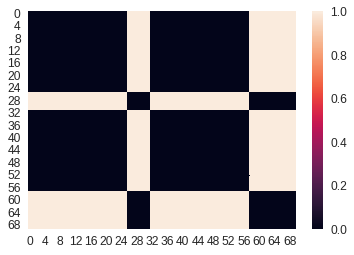

In [39]:
import seaborn as sns

sns.heatmap(mask_off_overlap.astype("int"))

In [40]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_off_ovlp(x, y):
    p = x.copy()
    p[mask_off_overlap] = (y.copy())[mask_off_overlap]
    return p

def embedd_batch_off_ovlp(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_off_ovlp(p_guess, p_conv))
    return np.array(p_embedded)


In [41]:
p_embedded_gwh_off_ovlp = embedd_batch_off_ovlp(p_embedded_gwh)

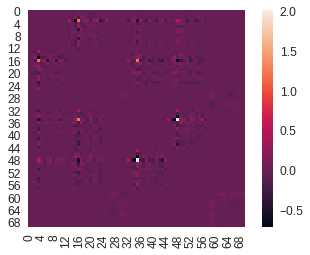

In [42]:
sns.heatmap(p_embedded_gwh_off_ovlp[0] - p_test[0], square=True)

In [43]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(fock_from_density_batch(p_embedded_gwh_off_ovlp)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 17:32:13: Iteration calculation: 0
[ ] 2019-01-07 17:32:15: Iteration calculation: 1
[ ] 2019-01-07 17:32:17: Iteration calculation: 2
[ ] 2019-01-07 17:32:19: Iteration calculation: 3
[ ] 2019-01-07 17:32:21: Iteration calculation: 4
[ ] 2019-01-07 17:32:23: Iteration calculation: 5
[ ] 2019-01-07 17:32:25: Iteration calculation: 6
[ ] 2019-01-07 17:32:27: Iteration calculation: 7
[ ] 2019-01-07 17:32:29: Iteration calculation: 8
[ ] 2019-01-07 17:32:31: Iteration calculation: 9
[ ] 2019-01-07 17:32:33: Iteration calculation: 10
[ ] 2019-01-07 17:32:35: Iteration calculation: 11
[ ] 2019-01-07 17:32:38: Iteration calculation: 12
[ ] 2019-01-07 17:32:40: Iteration calculation: 13
[ ] 2019-01-07 17:32:42: Iteration calculation: 14
[ ] 2019-01-07 17:32:44: Iteration calculation: 15
[ ] 2019-01-07 17:32:46: Iteration calculation: 16
[ ] 2019-01-07 17:32:48: Iteration calculation: 17
[ ] 2019-01-07 17:32:50: Iteration calculation: 18
[ ] 2019-01-07 17:32:51: Iteration calcul

[ ] 2019-01-07 17:37:32: Iteration calculation: 160
[ ] 2019-01-07 17:37:34: Iteration calculation: 161
[ ] 2019-01-07 17:37:36: Iteration calculation: 162
[ ] 2019-01-07 17:37:38: Iteration calculation: 163
[ ] 2019-01-07 17:37:40: Iteration calculation: 164
[ ] 2019-01-07 17:37:42: Iteration calculation: 165
[ ] 2019-01-07 17:37:44: Iteration calculation: 166
[ ] 2019-01-07 17:37:46: Iteration calculation: 167
[ ] 2019-01-07 17:37:48: Iteration calculation: 168
[ ] 2019-01-07 17:37:50: Iteration calculation: 169
[ ] 2019-01-07 17:37:52: Iteration calculation: 170
[ ] 2019-01-07 17:37:54: Iteration calculation: 171
[ ] 2019-01-07 17:37:56: Iteration calculation: 172
[ ] 2019-01-07 17:37:58: Iteration calculation: 173
[ ] 2019-01-07 17:38:00: Iteration calculation: 174
[ ] 2019-01-07 17:38:02: Iteration calculation: 175
[ ] 2019-01-07 17:38:04: Iteration calculation: 176
[ ] 2019-01-07 17:38:06: Iteration calculation: 177
[ ] 2019-01-07 17:38:08: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-07 17:42:16: Iteration calculation: 318
[ ] 2019-01-07 17:42:18: Iteration calculation: 319
[ ] 2019-01-07 17:42:20: Iteration calculation: 320
[ ] 2019-01-07 17:42:22: Iteration calculation: 321
[ ] 2019-01-07 17:42:24: Iteration calculation: 322
[ ] 2019-01-07 17:42:26: Iteration calculation: 323
[ ] 2019-01-07 17:42:28: Iteration calculation: 324
[ ] 2019-01-07 17:42:30: Iteration calculation: 325
[ ] 2019-01-07 17:42:32: Iteration calculation: 326
[ ] 2019-01-07 17:42:34: Iteration calculation: 327
[ ] 2019-01-07 17:42:36: Iteration calculation: 328
[ ] 2019-01-07 17:42:38: Iteration calculation: 329
[ ] 2019-01-07 17:42:40: Iteration calculation: 330
[ ] 2019-01-07 17:42:42: Iteration calculation: 331
[ ] 2019-01-07 17:42:43: Iteration calculation: 332
[ ] 2019-01-07 17:42:45: Iteration calculation: 333
[ ] 2019-01-07 17:42:47: Iteration calculation: 334
[ ] 2019-01-07 17:42:49: Iteration calculation: 335
[ ] 2019-01-07 17:42:51: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-07 17:47:40: Iteration calculation: 476
[ ] 2019-01-07 17:47:42: Iteration calculation: 477
[ ] 2019-01-07 17:47:44: Iteration calculation: 478
[ ] 2019-01-07 17:47:46: Iteration calculation: 479
[ ] 2019-01-07 17:47:48: Iteration calculation: 480
[ ] 2019-01-07 17:47:50: Iteration calculation: 481
[ ] 2019-01-07 17:47:52: Iteration calculation: 482
[ ] 2019-01-07 17:47:54: Iteration calculation: 483
[ ] 2019-01-07 17:47:55: Iteration calculation: 484
[ ] 2019-01-07 17:47:56: Iteration calculation: 485
[ ] 2019-01-07 17:47:56: Iteration calculation: 486
[ ] 2019-01-07 17:47:57: Iteration calculation: 487
[ ] 2019-01-07 17:47:58: Iteration calculation: 488
[ ] 2019-01-07 17:48:01: Iteration calculation: 489
[ ] 2019-01-07 17:48:02: Iteration calculation: 490
[ ] 2019-01-07 17:48:04: Iteration calculation: 491
[ ] 2019-01-07 17:48:06: Iteration calculation: 492
[ ] 2019-01-07 17:48:08: Iteration calculation: 493
[ ] 2019-01-07 17:48:10: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-07 17:52:56: Iteration calculation: 634
[ ] 2019-01-07 17:52:58: Iteration calculation: 635
[ ] 2019-01-07 17:53:00: Iteration calculation: 636
[ ] 2019-01-07 17:53:02: Iteration calculation: 637
[ ] 2019-01-07 17:53:04: Iteration calculation: 638
[ ] 2019-01-07 17:53:06: Iteration calculation: 639
[ ] 2019-01-07 17:53:09: Iteration calculation: 640
[ ] 2019-01-07 17:53:11: Iteration calculation: 641
[ ] 2019-01-07 17:53:13: Iteration calculation: 642
[ ] 2019-01-07 17:53:15: Iteration calculation: 643
[ ] 2019-01-07 17:53:17: Iteration calculation: 644
[ ] 2019-01-07 17:53:19: Iteration calculation: 645
[ ] 2019-01-07 17:53:21: Iteration calculation: 646
[ ] 2019-01-07 17:53:23: Iteration calculation: 647
[ ] 2019-01-07 17:53:25: Iteration calculation: 648
[ ] 2019-01-07 17:53:27: Iteration calculation: 649
[ ] 2019-01-07 17:53:29: Iteration calculation: 650
[ ] 2019-01-07 17:53:31: Iteration calculation: 651
[ ] 2019-01-07 17:53:32: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-07 17:58:21: Iteration calculation: 792
[ ] 2019-01-07 17:58:23: Iteration calculation: 793
[ ] 2019-01-07 17:58:25: Iteration calculation: 794
[ ] 2019-01-07 17:58:27: Iteration calculation: 795
[ ] 2019-01-07 17:58:29: Iteration calculation: 796
[ ] 2019-01-07 17:58:32: Iteration calculation: 797
[ ] 2019-01-07 17:58:34: Iteration calculation: 798
[ ] 2019-01-07 17:58:36: Iteration calculation: 799
[ ] 2019-01-07 17:58:38: Iteration calculation: 800
[ ] 2019-01-07 17:58:40: Iteration calculation: 801
[ ] 2019-01-07 17:58:42: Iteration calculation: 802
[ ] 2019-01-07 17:58:44: Iteration calculation: 803
[ ] 2019-01-07 17:58:46: Iteration calculation: 804
[ ] 2019-01-07 17:58:48: Iteration calculation: 805
[ ] 2019-01-07 17:58:50: Iteration calculation: 806
[ ] 2019-01-07 17:58:52: Iteration calculation: 807
[ ] 2019-01-07 17:58:54: Iteration calculation: 808
[ ] 2019-01-07 17:58:56: Iteration calculation: 809
[ ] 2019-01-07 17:58:58: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-07 18:03:41: Iteration calculation: 950
[ ] 2019-01-07 18:03:43: Iteration calculation: 951
[ ] 2019-01-07 18:03:44: Iteration calculation: 952
[ ] 2019-01-07 18:03:46: Iteration calculation: 953
[ ] 2019-01-07 18:03:48: Iteration calculation: 954
[ ] 2019-01-07 18:03:50: Iteration calculation: 955
[ ] 2019-01-07 18:03:52: Iteration calculation: 956
[ ] 2019-01-07 18:03:54: Iteration calculation: 957
[ ] 2019-01-07 18:03:56: Iteration calculation: 958
[ ] 2019-01-07 18:03:58: Iteration calculation: 959
[ ] 2019-01-07 18:04:00: Iteration calculation: 960
[ ] 2019-01-07 18:04:02: Iteration calculation: 961
[ ] 2019-01-07 18:04:04: Iteration calculation: 962
[ ] 2019-01-07 18:04:06: Iteration calculation: 963
[ ] 2019-01-07 18:04:08: Iteration calculation: 964
[ ] 2019-01-07 18:04:10: Iteration calculation: 965
[ ] 2019-01-07 18:04:12: Iteration calculation: 966
[ ] 2019-01-07 18:04:14: Iteration calculation: 967
[ ] 2019-01-07 18:04:16: Iteration calculation: 968
[ ] 2019-01-

In [44]:
7/len(p_test)

0.006993006993006993